# Project Definition

The goal of this project is to train a model to correctly predict which passengers survived the tragedy of the Titanic with above 70% accuracy. Maximizing the efficiency of the classifiers will not be observed in depth as the main focus is to practice their application. Juxtaposing various classifiers will help with understanding how the charactersistics of the dataset affect the performance of the algorithm.

# Imports & Data Preparation

In [1]:
#manipulation
import pandas as pd
import numpy as np

#visualization
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

#classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

#split training and testing data
from sklearn.model_selection import train_test_split

#metrics
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
#read in feature and label CSVs
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
test_label = pd.read_csv('gender_submission.csv')

In [3]:
#Combining the three data sets into one for future splitting and cross validation
mertest = pd.merge(test, test_label, on='PassengerId', how='outer')
titanic = pd.concat([train, mertest], ignore_index=True)
#Reorganize the columns to preserve original dataset order
titanic = titanic[['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']]

titanic.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


# Exploratory Data Analysis

## Missing Values

As we can see from the head of the Titanic dataframe, a noticeable portion of the Cabin column is missing. This raises the question, how many values are missing from our dataset?

Using a heatmap will help visualize our data and elucidate how to progress with the analysis.

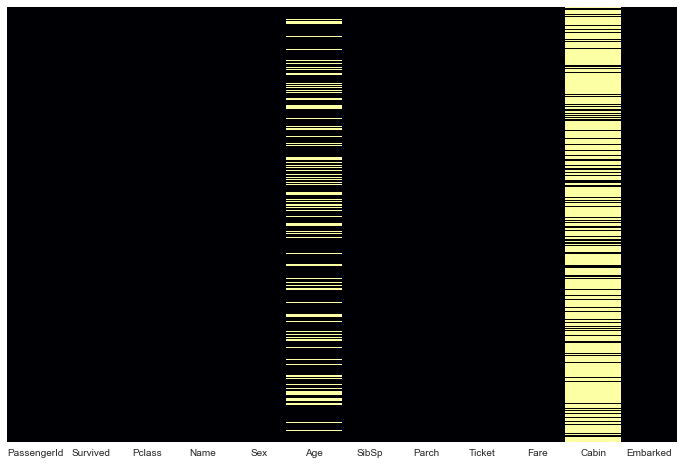

In [4]:
plt.figure(figsize=(12,8))
sns.heatmap(titanic.isnull(), yticklabels=False, cbar=False, cmap='inferno')

We can visibly see that the Cabin and Age columns are missing values, so let's go ahead and check the other columns for null values.

In [5]:
#The quickest method I thought of was to pass an isnull boolean series to return the rows with null values. 
titanic[titanic['Fare'].isnull() == True]
titanic[titanic['Embarked'].isnull() == True]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [6]:
#1. query boolean series from cabin and age columns 
#2. count the # of each boolean in the series and normalize
#3. convert to % and print
print('Percentage of null values in "Cabin" column:')
print(titanic['Cabin'].isnull().value_counts(normalize=True)[1]*100)
print('Percentage of null values in "Age" column:')
print(titanic['Age'].isnull().value_counts(normalize=True, ascending=True)[1]*100)
print('Percentage of null values in "Embarked" column:')
print(titanic['Embarked'].isnull().value_counts(normalize=True, ascending=True)[1]*100)
print('Percentage of null values in "Fare" column:')
print(titanic['Fare'].isnull().value_counts(normalize=True, ascending=True)[1]*100)

Percentage of null values in "Cabin" column:
77.4637127578
Percentage of null values in "Age" column:
20.0916730328
Percentage of null values in "Embarked" column:
0.152788388083
Percentage of null values in "Fare" column:
0.0763941940413


As we can see, 20% of our age data is missing, and nearly 80% of the cabin data is missing. It looks like too much of the cabin data is missing to do anything useful with it at a basic level. 

The cabin column will be dropped. The age column may be useful if we are able to fill the missing values. Exploratory data analysis will assist in determining if age imputation is a viable option.

In [7]:
#drop the Cabin column
titanic = titanic.drop('Cabin', axis=1)

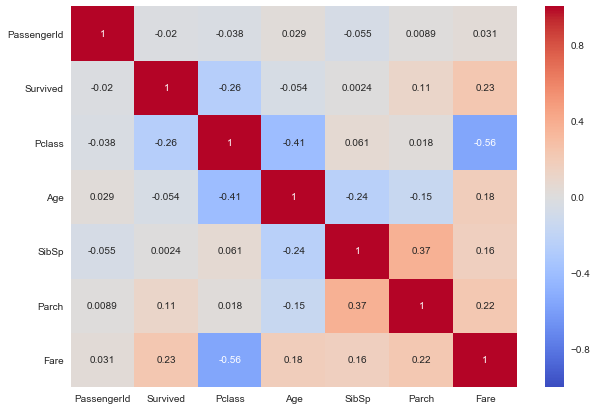

In [8]:
plt.figure(figsize=(10,7))
sns.heatmap(titanic.corr(), annot=True, cmap='coolwarm')

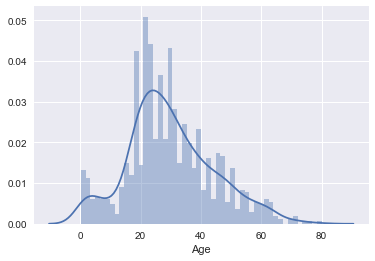

In [9]:
sns.distplot(titanic['Age'].dropna(), bins=50)

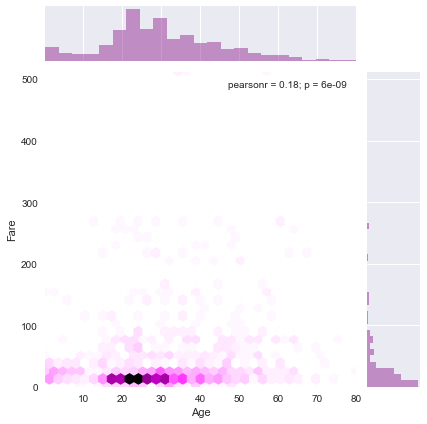

In [10]:
sns.jointplot(data=titanic, x='Age', y='Fare', kind='hex', gridsize=35, color='purple')

In [11]:
print('The average fare for Class 1 is: ${}'.format(titanic[titanic['Pclass'] == 1]['Fare'].mean()))
print('The average fare for Class 2 is: ${}'.format(titanic[titanic['Pclass'] == 2]['Fare'].mean()))
print('The average fare for Class 3 is: ${}'.format(titanic[titanic['Pclass'] == 3]['Fare'].mean()))

The average fare for Class 1 is: $87.5089916408668
The average fare for Class 2 is: $21.1791963898917
The average fare for Class 3 is: $13.302888700564969


There's quite a jump in average fare between the classes. First class tends to have access to more amenities and connections than third class would, let's see if that had an effect on survival rate amongst the classes.

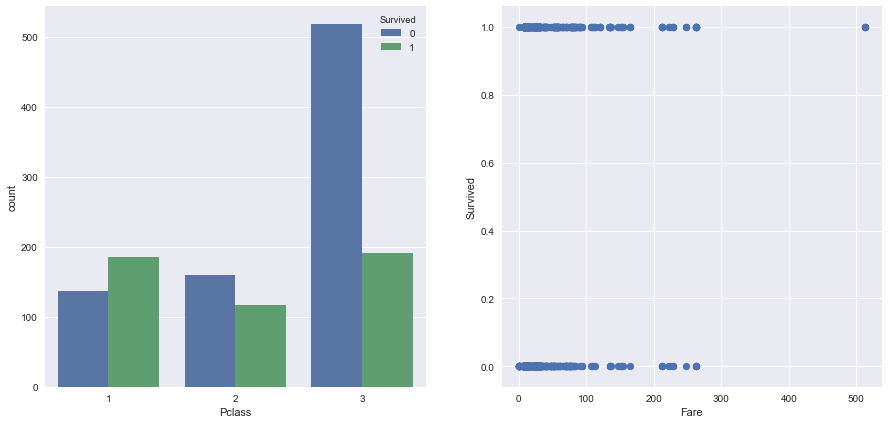

In [12]:
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
sns.countplot(data=titanic, x='Pclass', hue='Survived', ax=ax1)
plt.scatter(data=titanic, x='Fare', y='Survived')

ax2.set_xlabel('Fare')
ax2.set_ylabel('Survived')

As we thought, survival rate dramatically from the third to first classes. We can see that wealth does play a part in surviving the tragedy. How does age interact with the wealth gap? Perhaps the elderly or youth were favored.

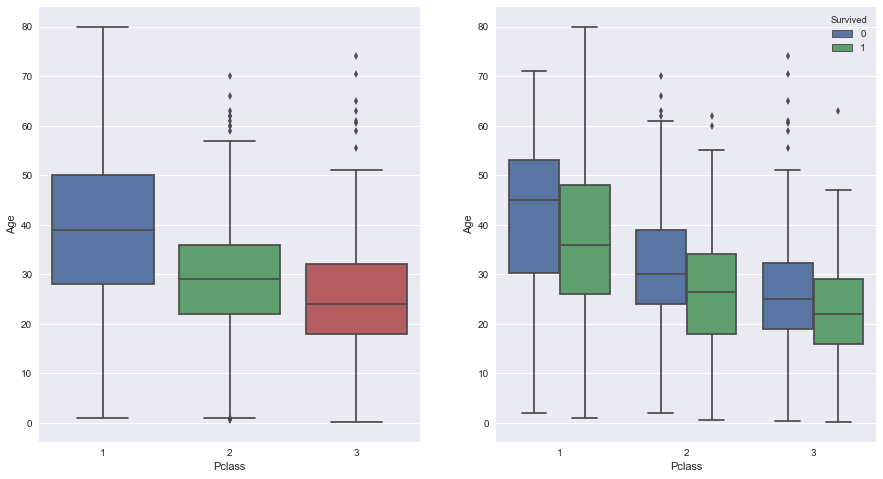

In [13]:
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

sns.boxplot(data=titanic, y='Age', x='Pclass', ax=ax1)
sns.boxplot(data=titanic, y='Age', x='Pclass', hue='Survived', ax=ax2)

It seems like wealth is a primary factor when it comes to survival. The average age increases from third to first class as older people tend to be established in their career and have more expendable income. Being older comes with a penalty to survival rate, most noticably in first class.

As an initial imputation, the average age of each Pclass will be used to fill the null values in the Age column.

In [14]:
#save the mean age of each pclass as variables
pc1mean = round(titanic[titanic['Pclass'] == 1]['Age'].mean(),0)
pc2mean = round(titanic[titanic['Pclass'] == 2]['Age'].mean(),0)
pc3mean = round(titanic[titanic['Pclass'] == 3]['Age'].mean(),0)

def impute_age(cols): #pass in DataFrame of Age and Class
    Age = cols[0]
    Class = cols[1]
    
    if pd.isnull(Age): #if Age series is null, proceed to next if statement
        
        if Class == 1: #return average age of Pclass and append into Age series
            return pc1mean
        elif Class == 2:
            return pc2mean
        else:
            return pc3mean
        
    else: #if passed in Age is not null, return the value that is present
        return Age

In [15]:
titanic['Age'] = titanic[['Age', 'Pclass']].apply(impute_age, axis=1)

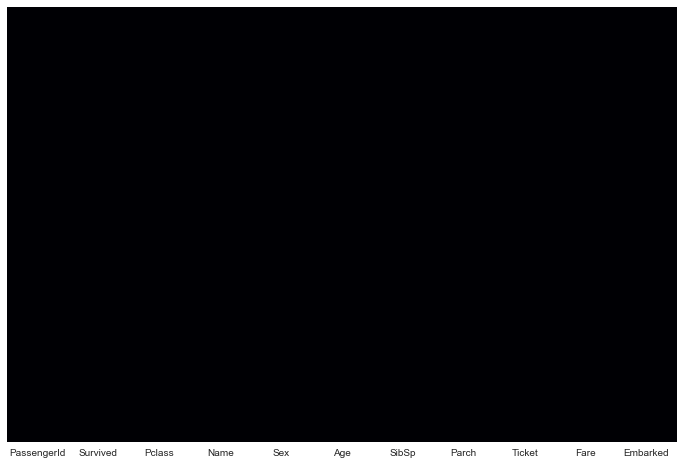

In [16]:
plt.figure(figsize=(12,8))
sns.heatmap(titanic.isnull(), yticklabels=False, cbar=False, cmap='inferno')

The age column is cleaned and ready to be analyzed. We still have a few nulls in our dataframe, so let's assess how we can salvage those rows.

In [17]:
titanic[titanic['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,NaN


The Fare and Pclass seem to indicate that both of these passengers embarked from the same location. The fares are relatively close to our calculated average fare for first class as well.

Checking the average fare by class for each embarking point should give a better idea as to where these passengers embarked.

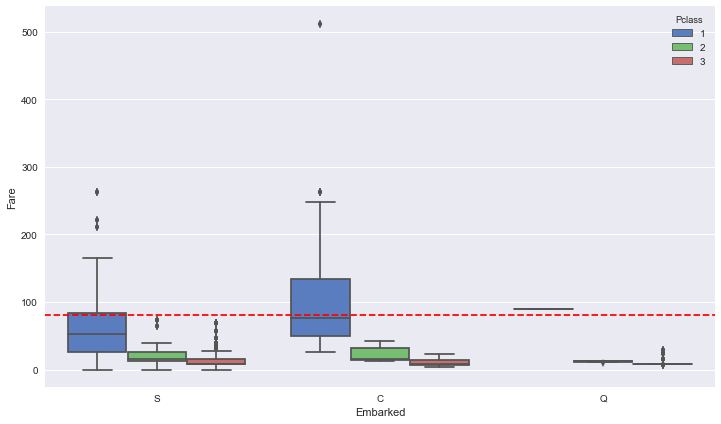

In [18]:
plt.figure(figsize=(12, 7))
sns.boxplot(data=titanic, x='Embarked', y='Fare', hue='Pclass', palette='muted')
#plot horizontal line at 80 representing Fare of passengers in question
plt.hlines(80, xmin=-1, xmax=3, linestyles='--', color='red')

The fare paid by the passengers in question nicely matches up with the median of the first class that embarked from C. Location C will be used as the point of embarkation.

In [19]:
titanic['Embarked'] = titanic['Embarked'].fillna(value='C')

There's one last null value that needs to be sorted out. The fare of passenger Id 1044 is still null. How can we best estimate what he paid for his fare given the information we do have about him?

We can calculate a fair estimate for his fare by using the average fare of passengers within his class that embarked from the same location.

In [20]:
titanic[titanic['Fare'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
1043,1044,0,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,S


In [21]:
avgfare = round(titanic[(titanic['Pclass'] == 3) & (titanic['Embarked'] == 'S')]['Fare'].mean(),2)
print('The avg. fare for passengers in 3rd class that embarked from "S" is: ${}'.format(avgfare))

The avg. fare for passengers in 3rd class that embarked from "S" is: $14.44


In [22]:
titanic[titanic['Fare'].isnull()] = titanic[titanic['Fare'].isnull()].fillna(14.44)

# Feature Engineering

Now that the data is cleaned and all null values are filled, we can work on feature engineering.

## Titles

The first two categories that catch my eye are the Name and Ticket columns, it seems like we can pull additional useful variables from the entries. I'd like to estimate race based off of family names, but to keep it simple we'll just focus on titles.

In [23]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [24]:
titanic['Title'] = titanic['Name'].apply(lambda x: x.split()[1])
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Mr.
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mrs.
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss.
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Mrs.
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,Mr.


In [25]:
titanic['Title'].value_counts()

Mr.             736
Miss.           256
Mrs.            191
Master.          59
Dr.               8
Rev.              8
y                 8
Col.              4
Planke,           4
Impe,             3
Billiard,         3
Carlo,            2
Major.            2
Gordon,           2
Messemaeker,      2
Ms.               2
Mlle.             2
Cruyssen,         1
the               1
Shawah,           1
Melkebeke,        1
Walle,            1
Jonkheer.         1
Don.              1
Khalil,           1
Palmquist,        1
Steen,            1
Pelsmaeker,       1
Mme.              1
der               1
Brito,            1
Capt.             1
Mulder,           1
Velde,            1
Name: Title, dtype: int64

In [26]:
#define a function that will split the name strings and return their title, rare titles will be grouped into their own category.
def title_class(col):
    common = ['Mr.', 'Ms.', 'Mrs.', 'Miss.']
    if col == 'Master.':
        return 'Mr.'
    elif col == 'Ms.':
        return 'Miss.'
    elif col not in common:
        return 'Rare Title'
    else:
        return col

In [27]:
#apply our function to the title column to transform it
titanic['Title'] = titanic['Title'].apply(title_class)

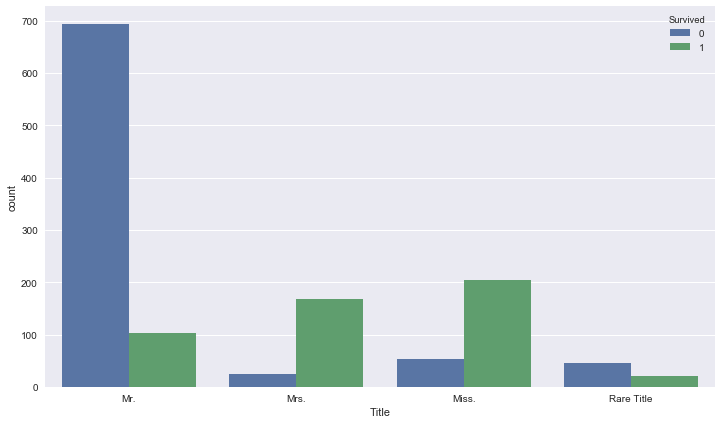

In [28]:
plt.figure(figsize=(12,7))
sns.countplot(data=titanic, x='Title', hue='Survived')

As we can see, being a male comes with a massive pentalty to survival rate. Women and children are always the priority and most likely were shuffled onto the safety boats before men. We can see that women have a much better survival rate, we'll look into children as part of family composition.

## Family Composition: The lone wolf dies, but the pack survives?

Another interesting feature to investigate is family composition. Does having a significant other/children/sibiling/parent affect chances of survival? Was total family size taken into consideration when deciding which passengers would board the boats?

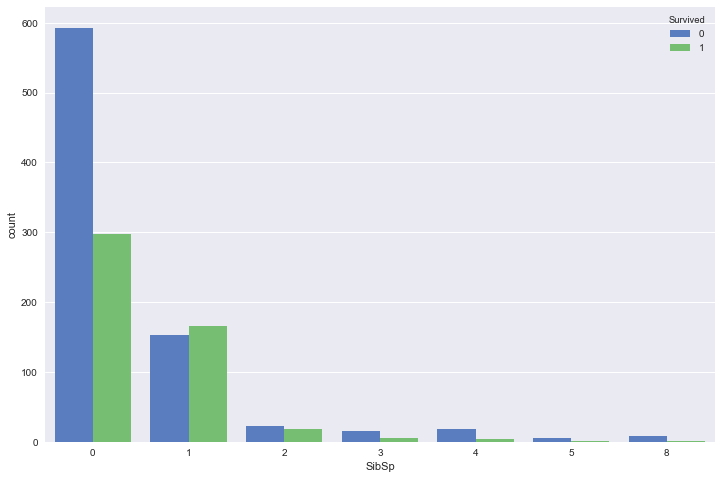

In [29]:
plt.figure(figsize=(12,8))
sns.countplot(x=titanic['SibSp'], hue=titanic['Survived'], palette='muted')

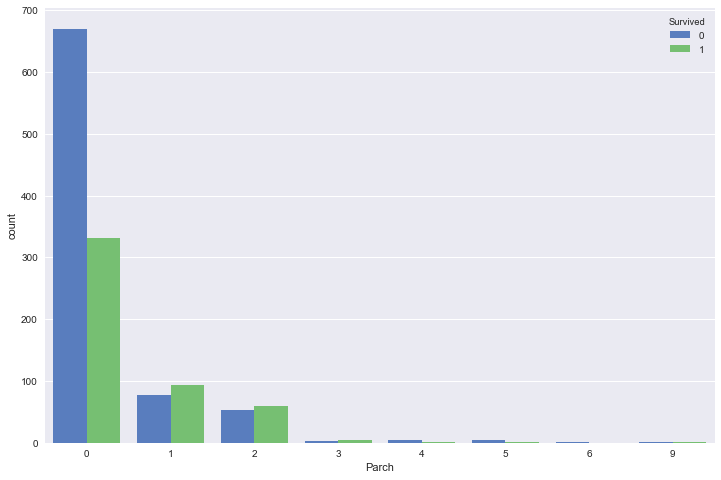

In [30]:
plt.figure(figsize=(12,8))
sns.countplot(data=titanic, x='Parch', hue='Survived', palette='muted')

We can see that there's a penalty for having no siblings/spouses or parents/children, and having one family member improves survival chance. From that point onward, there are varied results. Viewing the family size as a single variable rather than two separate ones will help paint a broader picture of the interaction between family size and survival.

In [31]:
titanic['Family Size'] = titanic['SibSp'] + titanic['Parch']

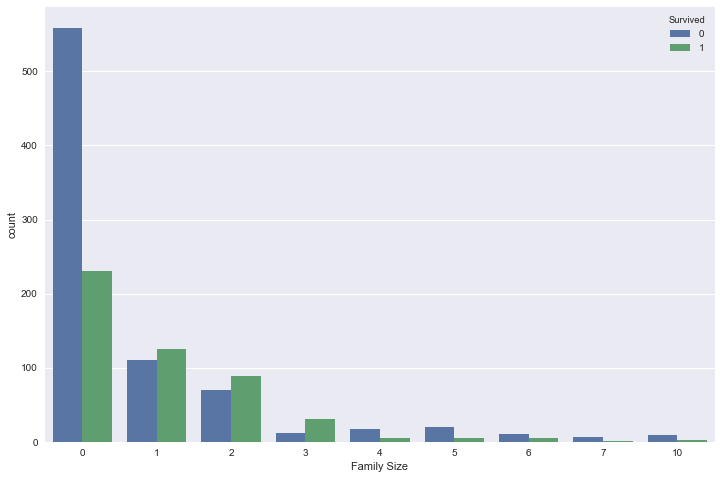

In [32]:
plt.figure(figsize=(12,8))
sns.countplot(data=titanic, x='Family Size', hue='Survived')

So it seems to be that if you were alone on the ship, your chances of survival were greatly reduced. Between 1 to 3 family members leads to an increased survival chance before dropping off again at 4+.

## Is the survival of children the first priority?

Typically, humans will sacrifice their life if it means giving children a chance to live. In the case of the Titanic, does that lead to higher survival rate for children? Do fathers and mothers have the same survival rate?

To start exploring this topic, we'll first start by defining what a child, mother, and father are for our purposes:

    1) A mother will be any female passenger over the Age of 18, with at least one child.
    2) A father will be any male passenger over the Age of 18, with at least one child.
    3) A child will be any passenger under the Age of 18.

The division between adult and child was quite different in the early 1900s. A 17 year old was most likely working and considered an adult by that point, but we'll use 18 for ease of analysis.

In [33]:
def child_define(cols):
    Sex = cols[0]
    Age = cols[1]

    if Sex == 'male': 
        if Age > 18:
            return 'Father'
        else:
            return 'Child'
    elif Sex == 'female':
        if Age > 18:
            return 'Mother'
        else:
            return 'Child'

In [34]:
titanic['PorC'] = titanic[['Sex','Age']].apply(child_define, axis=1)
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,Family Size,PorC
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Mr.,1,Father
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mrs.,1,Mother
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss.,0,Mother
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Mrs.,1,Mother
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,Mr.,0,Father


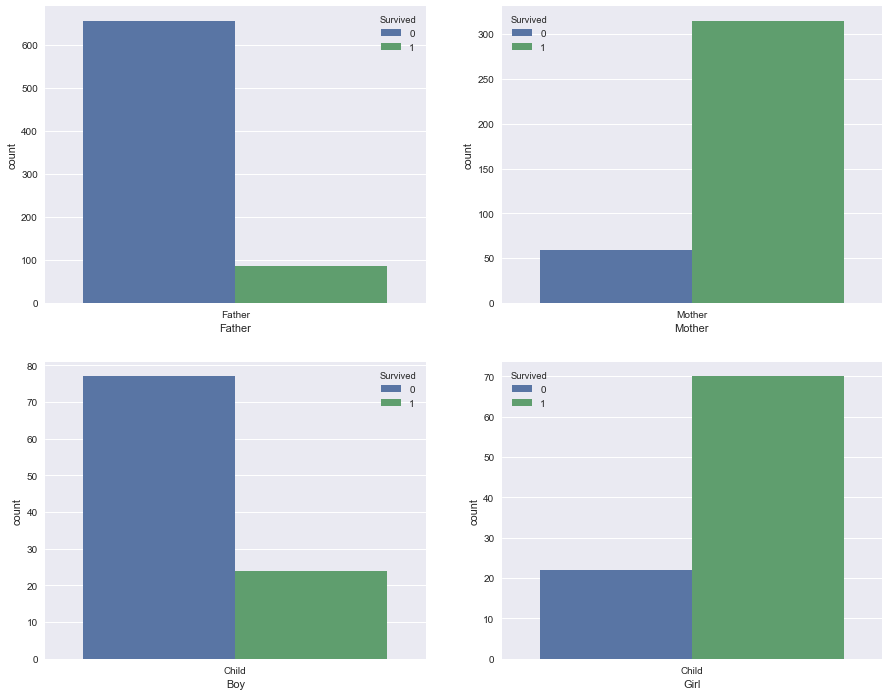

In [35]:
#create figure object and 4 axes objects where we will add a subplot to each. Each subplot is being passed 2 cols, 2 rows 
#as their dimension, and then their position in that 4x4 grid
fig = plt.figure(figsize=(15,12))
axes1 = fig.add_subplot(221)
axes2 = fig.add_subplot(222)
axes3 = fig.add_subplot(223)
axes4 = fig.add_subplot(224)

#fill each of the 4 subplot objects with countplots
sns.countplot(data=titanic[titanic['PorC'] == 'Father'], x='PorC', hue='Survived', ax=axes1)
sns.countplot(data=titanic[titanic['PorC'] == 'Mother'], x='PorC', hue='Survived', ax=axes2)
sns.countplot(data=titanic[(titanic['PorC'] == 'Child') & (titanic['Sex'] == 'male')], x='PorC', hue='Survived', ax=axes3)
sns.countplot(data=titanic[(titanic['PorC'] == 'Child') & (titanic['Sex'] == 'female')], x='PorC', hue='Survived', ax=axes4)

#Set the x axis label to indentify parent gender or child gender
axes1.set_xlabel('Father')
axes2.set_xlabel('Mother')
axes3.set_xlabel('Boy')
axes4.set_xlabel('Girl')

The difference in survival rate between genders is expected, being male leads to an extreme pentalty on survival rate. 

Our initial assumption that children will have a higher survival rate was only partially correct. Boys have a higher survival rate when compared to fathers, but girls have a lower survival rate when compared to mothers. The conclusion: being a woman held a higher bonus to survival rate than being a child did.

# Prediction

## Classifiers

From here, the project will split into several paths in order to test the performance of a variety of classifiers on this data set. The following classifiers will be used to predict the survival rate of the passengers:

    1) Logistic Regression
    2) K Nearest Neighbors
    3) Support Vector Machines
    4) Decision Tree
    5) Random Forest
    6) Stochastic Gradient Descent
    6b) Stochastic Gradient Descent w/ Kernel Approximation

I predict that the Random Forest model will perform the best given the characteristics of the dataset. Let's see if the prediction is accurate!

## Logistic Regression

### Converting Categorical Features

In [36]:
titanicLR = pd.DataFrame()
titanicLR = titanic

We'll need to convert our categorical features into variables so that the algorithm can directly take them in as input. To do this, we'll be using dummy variables.

Out of the columns with categorical features, we can easily pull valuable information from the Sex and Embarked columns. Title and PorC is relative to Age and Sex, so no need to convert those. 

In [37]:
#drop the first column to avoid multi-colinearity, female column would be a perfect predictor for male column for example
#passing in multiple perfect predictor columns would lower the performance of the algorithm
sex = pd.get_dummies(titanic['Sex'], drop_first=True)
embark = pd.get_dummies(titanic['Embarked'], drop_first=True)

In [38]:
#drop all categorical feature columns, including the now redundant Sex and Embarked
titanicLR.drop(['Sex', 'Embarked', 'Name', 'Ticket', 'Title', 'PorC'], axis=1, inplace=True)
#add new dummy variable columns to the dataframe
titanicLR = pd.concat([titanicLR, sex, embark], axis=1)
titanicLR.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Family Size,male,Q,S
0,1,0,3,22.0,1,0,7.2500,1,1,0,1
1,2,1,1,38.0,1,0,71.2833,1,0,0,0
2,3,1,3,26.0,0,0,7.9250,0,0,0,1
3,4,1,1,35.0,1,0,53.1000,1,0,0,1
4,5,0,3,35.0,0,0,8.0500,0,1,0,1


To avoid overfitting our models, we will be using train_test_split for cross validation.

In [39]:
#Split up training set into features and labels
LRX = titanicLR.drop('Survived', axis=1)
LRy = titanicLR['Survived']

LRX_train, LRX_test, LRy_train, LRy_test = train_test_split(LRX, LRy, test_size=0.30)

In [40]:
#Create a Logistic Regression object and fit it to the training data
logmodel = LogisticRegression()
logmodel.fit(LRX_train, LRy_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [41]:
#use model to make predictions off of X testing set
LRpred = logmodel.predict(LRX_test)

In [42]:
print(confusion_matrix(LRy_test, LRpred))
print('\n')
print(classification_report(LRy_test, LRpred))

[[227  23]
 [ 31 112]]


             precision    recall  f1-score   support

          0       0.88      0.91      0.89       250
          1       0.83      0.78      0.81       143

avg / total       0.86      0.86      0.86       393



## Support Vector Machines

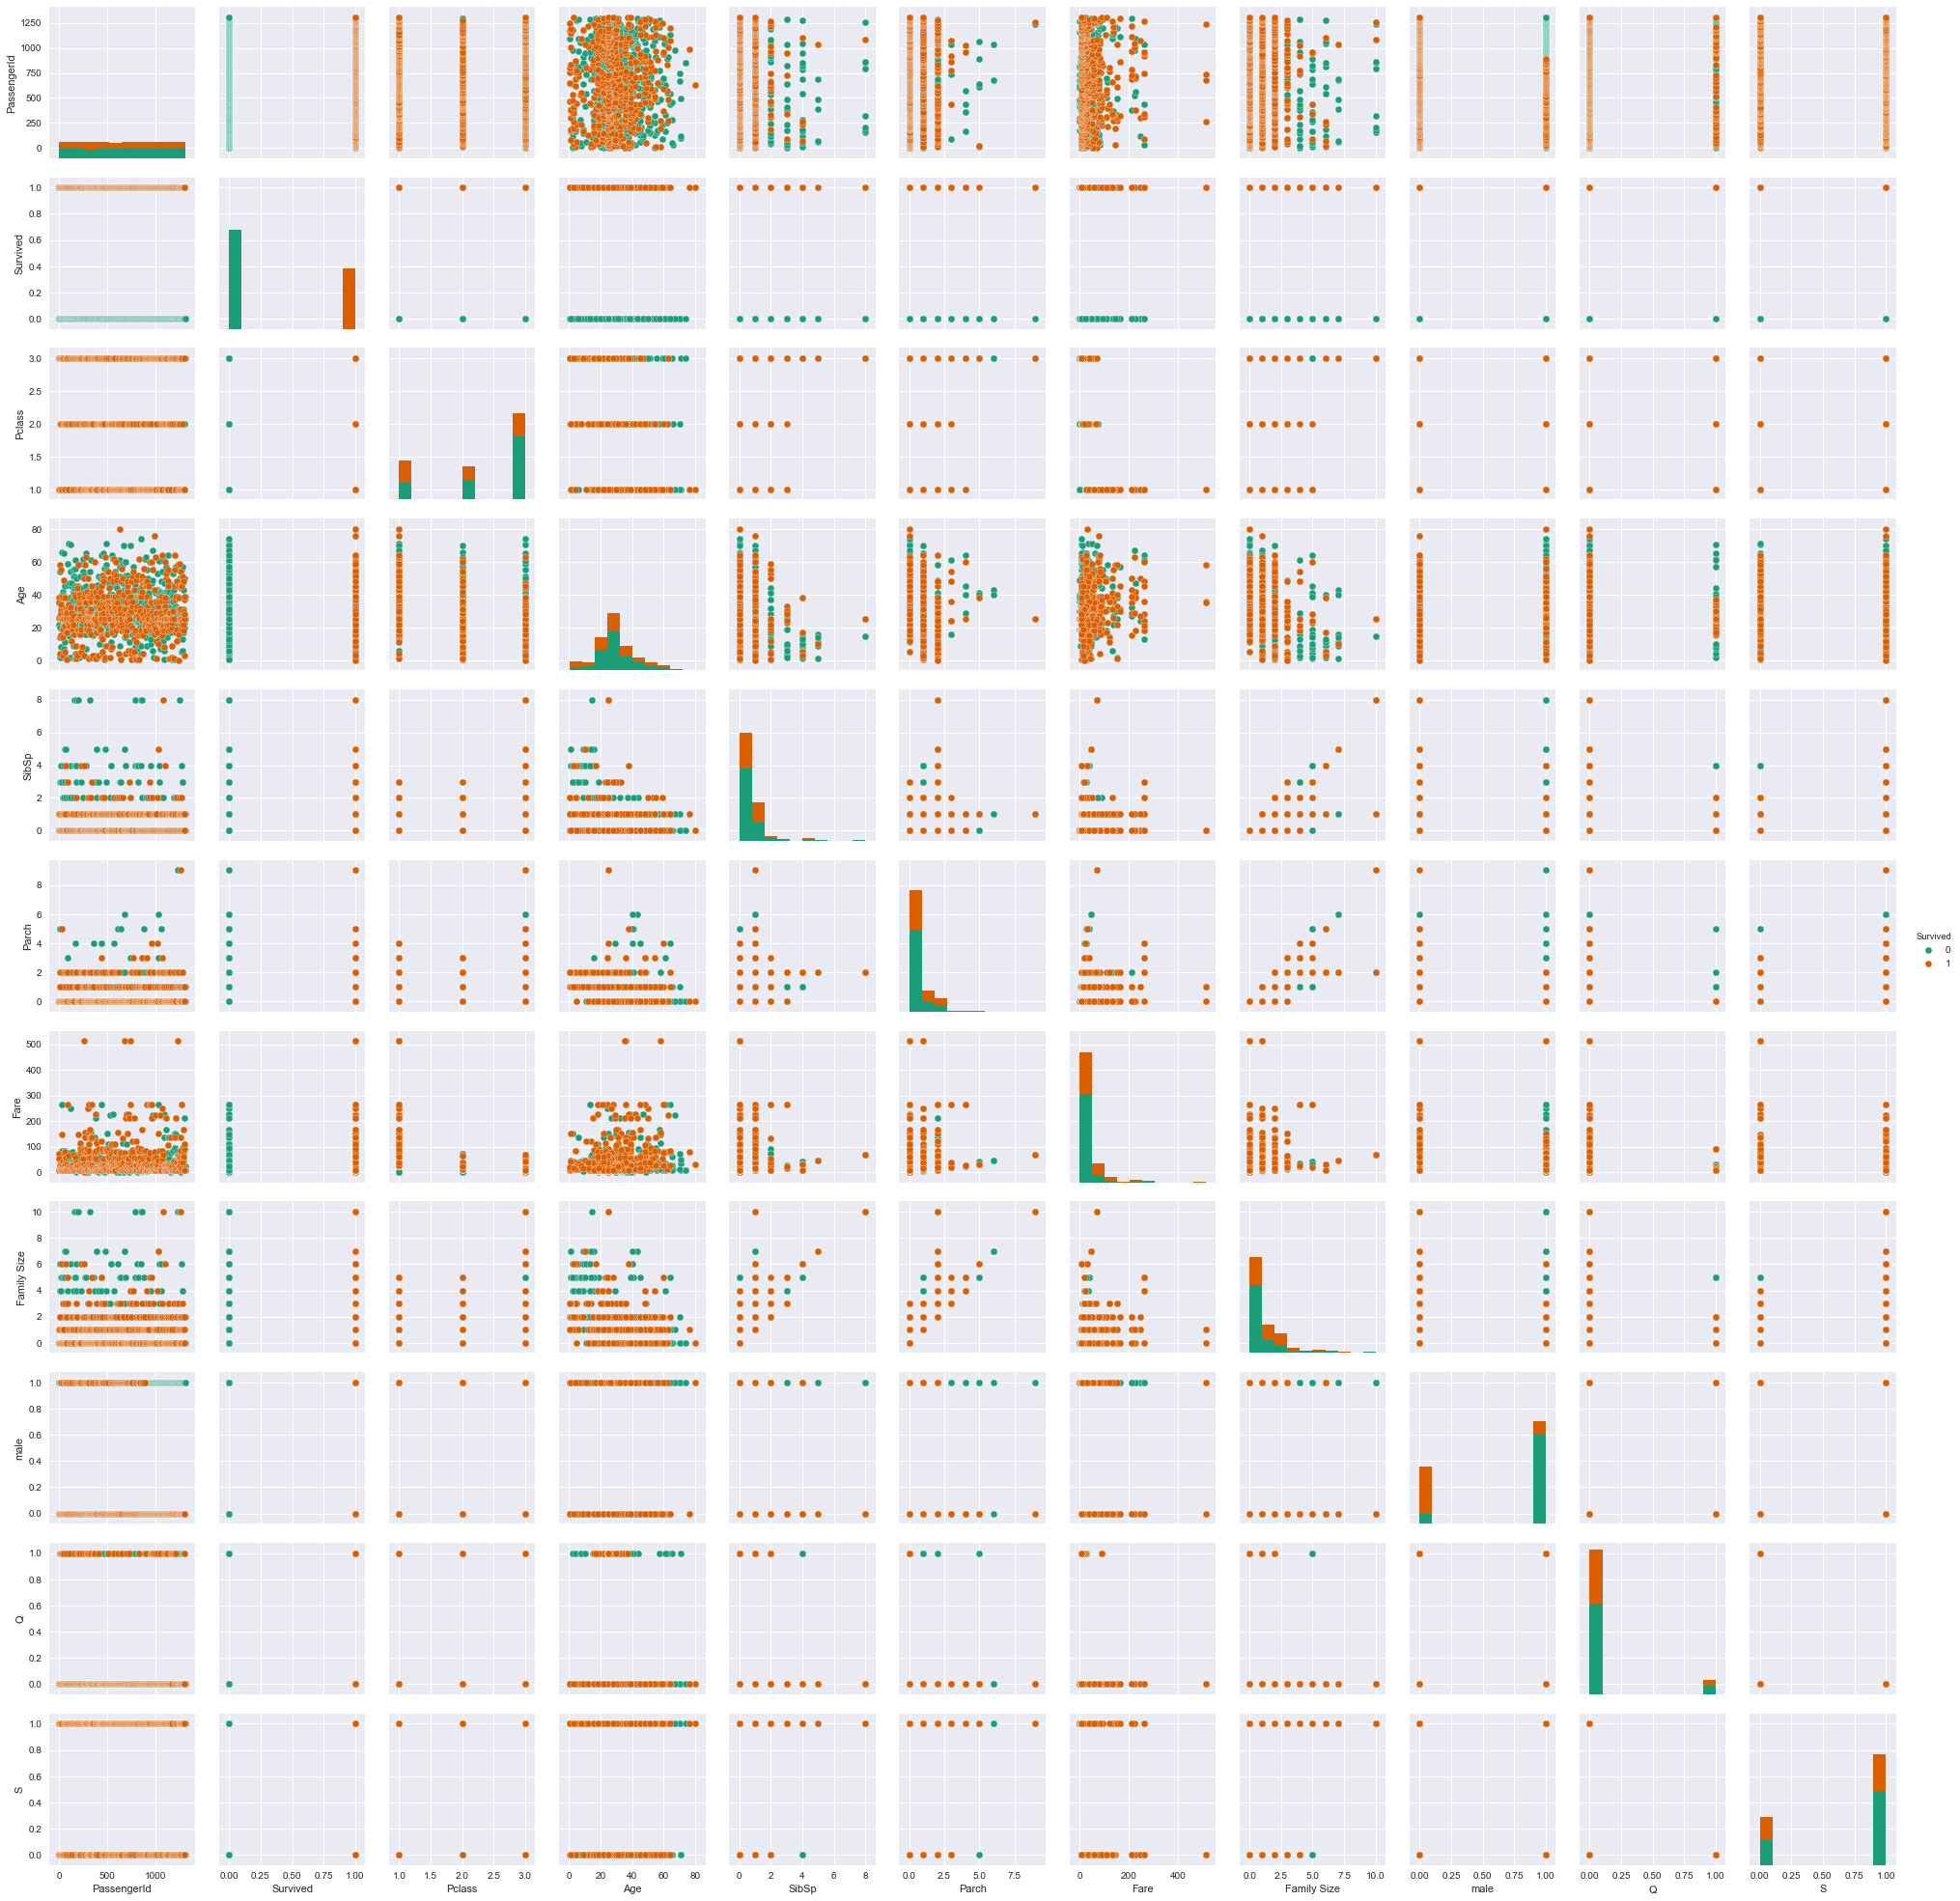

In [45]:
titanicS = titanicLR
sns.pairplot(titanicS, hue='Survived', palette='Dark2')

Our pairplot indicates that there is poor separation between the labels we want to predict. My prediction is that the SVC algorithm will have low accuracy in prediction.

In [46]:
#Add dummies and drop categorical columns
SX = titanicS.drop('Survived', axis=1)
Sy = titanicS['Survived']

SX_train, SX_test, Sy_train, Sy_test = train_test_split(SX, Sy, test_size=0.30)

In [47]:
SVC_model = SVC()
SVC_model.fit(SX_train, Sy_train)

Spred = SVC_model.predict(SX_test)

In [48]:
print(confusion_matrix(Sy_test, Spred))
print('\n')
print(classification_report(Sy_test, Spred))

[[233   2]
 [156   2]]


             precision    recall  f1-score   support

          0       0.60      0.99      0.75       235
          1       0.50      0.01      0.02       158

avg / total       0.56      0.60      0.46       393



## Decision Trees

In [49]:
titanicDT = titanicLR

DTX = titanicDT.drop('Survived', axis=1)
DTy = titanicDT['Survived']

DTX_train, DTX_test, DTy_train, DTy_test = train_test_split(DTX, DTy, test_size=0.30)

In [50]:
titanicDT.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Family Size,male,Q,S
0,1,0,3,22.0,1,0,7.2500,1,1,0,1
1,2,1,1,38.0,1,0,71.2833,1,0,0,0
2,3,1,3,26.0,0,0,7.9250,0,0,0,1
3,4,1,1,35.0,1,0,53.1000,1,0,0,1
4,5,0,3,35.0,0,0,8.0500,0,1,0,1


In [51]:
DT_model = DecisionTreeClassifier()
DT_model.fit(DTX_train, DTy_train)

DTpred = DT_model.predict(DTX_test)

In [52]:
print(confusion_matrix(DTy_test, DTpred))
print('\n')
print(classification_report(DTy_test, DTpred))

[[213  32]
 [ 45 103]]


             precision    recall  f1-score   support

          0       0.83      0.87      0.85       245
          1       0.76      0.70      0.73       148

avg / total       0.80      0.80      0.80       393



## Random Forest

In [53]:
#create RFC object and fit to training data
RFC_model = RandomForestClassifier()
RFC_model.fit(DTX_train, DTy_train)

#prediciton
RFCpred = RFC_model.predict(DTX_test)

In [54]:
print(confusion_matrix(DTy_test, RFCpred))
print('\n')
print(classification_report(DTy_test, RFCpred))

[[231  14]
 [ 35 113]]


             precision    recall  f1-score   support

          0       0.87      0.94      0.90       245
          1       0.89      0.76      0.82       148

avg / total       0.88      0.88      0.87       393



## K Nearest Neighbors

In [55]:
titanicLR.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Family Size,male,Q,S
0,1,0,3,22.0,1,0,7.2500,1,1,0,1
1,2,1,1,38.0,1,0,71.2833,1,0,0,0
2,3,1,3,26.0,0,0,7.9250,0,0,0,1
3,4,1,1,35.0,1,0,53.1000,1,0,0,1
4,5,0,3,35.0,0,0,8.0500,0,1,0,1


In [56]:
#Because Fare and Age have greater variation than the rest of the columns, we need to standardize the matrix
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [57]:
titanicKNN = titanicLR

scaler.fit(titanicKNN.drop('Survived', axis=1))
scaled_features = scaler.transform(titanicKNN.drop('Survived', axis=1))

tKNN_scaled = pd.DataFrame(scaled_features, columns=['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Family Size', 'male', 'Q', 'S'])
tKNN_scaled.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Family Size,male,Q,S
0,-1.730728,0.841916,-0.562845,0.481288,-0.445,-0.503291,0.073352,0.743497,-0.32204,0.657394
1,-1.728082,-1.546098,0.657637,0.481288,-0.445,0.734744,0.073352,-1.344995,-0.32204,-1.521159
2,-1.725435,0.841916,-0.257725,-0.479087,-0.445,-0.490240,-0.558346,-1.344995,-0.32204,0.657394
3,-1.722789,-1.546098,0.428796,0.481288,-0.445,0.383184,0.073352,-1.344995,-0.32204,0.657394
4,-1.720143,0.841916,0.428796,-0.479087,-0.445,-0.487823,-0.558346,0.743497,-0.32204,0.657394


In [58]:
KNNX_train, KNNX_test, KNNy_train, KNNy_test = train_test_split(tKNN_scaled, titanicKNN['Survived'], test_size=0.3)

KNN_model = KNeighborsClassifier(n_neighbors=1)
KNN_model.fit(KNNX_train, KNNy_train)
KNNpred = KNN_model.predict(KNNX_test)

In [59]:
print(confusion_matrix(KNNy_test, KNNpred))
print('\n')
print(classification_report(KNNy_test, KNNpred))

[[234  35]
 [ 35  89]]


             precision    recall  f1-score   support

          0       0.87      0.87      0.87       269
          1       0.72      0.72      0.72       124

avg / total       0.82      0.82      0.82       393



Let's see if we can optimize the KNN model any more by determining if there is a more optimal K value. The elbow method will help us by keeping visualizing the error rate amongst different k values.

In [60]:
error_rate = []

for i in range (1,40):
    '''
    1. Check every value between 1 to 40
    2. Create KNeighborsClassifier object with K value = i 
    3. Use model to predict target values at every K value
    4. When the predicted target value does not equal the actual target value,
       then add the average error rate to the error_rate list 
    '''
    
    KNN_model = KNeighborsClassifier(n_neighbors=i)
    KNN_model.fit(KNNX_train, KNNy_train)
    pred_i = KNN_model.predict(KNNX_test)
    error_rate.append(np.mean(pred_i != KNNy_test))

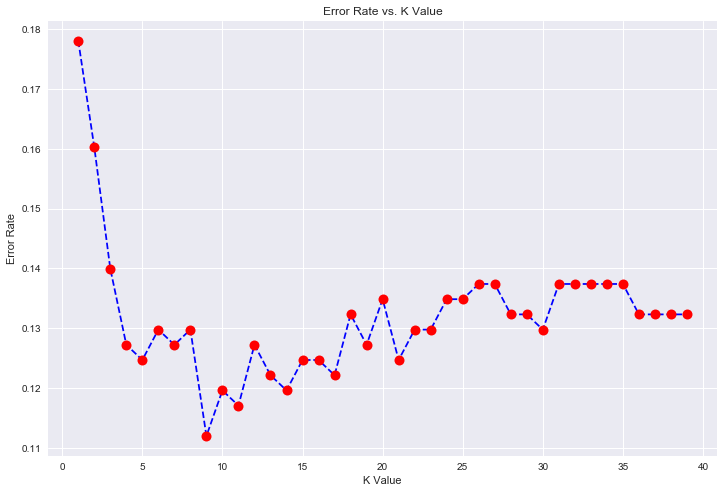

In [61]:
#visualize the elbow method
plt.figure(figsize=(12,8))
plt.plot(range(1,40), error_rate, color='blue', linestyle='--', marker='o', markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K Value')
plt.ylabel('Error Rate')

Using the elbow method, we see that we hit a minimum error rate at K=9 which leads to a more accurate model with slightly increased runtime. We could increase the K value to see what lies beyond 40 but the hit to performance isn't worth the slight potential increase in accuracy for our purposes.

In [68]:
# NOW WITH K=9
KNN_model = KNeighborsClassifier(n_neighbors=9)

KNN_model.fit(KNNX_train, KNNy_train)
pred = KNN_model.predict(KNNX_test)

print('WITH K=9')
print('\n')
print(confusion_matrix(KNNy_test,pred))
print('\n')
print(classification_report(KNNy_test,pred))

WITH K=9


[[257  12]
 [ 32  92]]


             precision    recall  f1-score   support

          0       0.89      0.96      0.92       269
          1       0.88      0.74      0.81       124

avg / total       0.89      0.89      0.89       393



## SGD Classifier

In [63]:
titanicSGD = titanicLR
SGDX = titanicSGD.drop('Survived', axis=1)
SGDy = titanicSGD['Survived']

SGDX_train, SGDX_test, SGDy_train, SGDy_test = train_test_split(SGDX, SGDy, test_size=0.3)

scaler = StandardScaler()
scaler.fit(SGDX_train)
SGDX_train = scaler.transform(SGDX_train)
SGDX_test = scaler.transform(SGDX_test)  # apply same transformation to test data

In [64]:
SGD_model = SGDClassifier(loss="hinge", penalty="l2") #Classifier object
SGD_model.fit(SGDX_train, SGDy_train) #Model fitting

SGDpred = SGD_model.predict(SGDX_test) #predicitons

In [65]:
print(confusion_matrix(SGDy_test, SGDpred))
print('\n')
print(classification_report(SGDy_test, SGDpred))

[[225  25]
 [ 41 102]]


             precision    recall  f1-score   support

          0       0.85      0.90      0.87       250
          1       0.80      0.71      0.76       143

avg / total       0.83      0.83      0.83       393



Let's see if we can improve the results by using kernel approximation

In [66]:
#Creating Radial Basis Function Object
rbf_feature = RBFSampler(gamma=1, random_state=1)
KAX_train = rbf_feature.fit_transform(SGDX_train)
KAX_test = rbf_feature.fit_transform(SGDX_test)

KA_model = SGDClassifier(loss="hinge", penalty="l2") #Classifier object
KA_model.fit(KAX_train, SGDy_train) #Model fitting

KApred = KA_model.predict(KAX_test) #predicitons

In [67]:
print(confusion_matrix(SGDy_test, KApred))
print('\n')
print(classification_report(SGDy_test, KApred))

[[247   3]
 [122  21]]


             precision    recall  f1-score   support

          0       0.67      0.99      0.80       250
          1       0.88      0.15      0.25       143

avg / total       0.74      0.68      0.60       393



# Conclusion

So, it turns out that the K Nearest Neighbors algorithm produced the best results in terms of accuracy. The rankings in terms of accuracy are below:

|      Classifier      | Precision | Recall | f1-score |
|----------------------|-----------|--------|----------|
| K Nearest Neighbors  |    0.89   |  0.89  | 0.89     |
| Random Forest        |    0.88   |  0.88  | 0.87     |
| Logistic Regression  |    0.85   |  0.85  | 0.85     |
| SGD                  |    0.83   |  0.83  | 0.83     |
| Decision Trees       |    0.80   |  0.80  | 0.80     |
| SGD w/ Kernel Approx.|    0.74   |  0.68  | 0.60     |
| SVC                  |    0.86   |  0.60  | 0.46     |

    1) Classifiers that require clear separation between the labels of features did not perform well with this dataset.
    2) Logistic Regression, Decision Trees, and Random Forest all performed well with no optimization. When performing quick 
    data analysis, they are probably the best choice.
    3) Relatively low dimensionality played to KNN's strengths and allowed it to perform well.
    4) Each classifier performs differently when it comes to the precision, recall, and f1-score, as well as the ability to
    predict death or survival. SGD w/KA may be terrible at recall of survival (1), but it is almost 100% accurate in 
    recalling death (0). Knowing which model to use requires understanding of what values are the most important to your
    application or business.
